In [1]:
import astropy as ast
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris, EarthLocation, GeocentricTrueEcliptic, get_body, SkyCoord
import jdcal # for conversion to Julian day
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

In [2]:
# For visualization/plotting
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from pandas.plotting import register_matplotlib_converters
from sklearn.metrics import plot_confusion_matrix
register_matplotlib_converters()

In [3]:
# For surpressing future warnings and similar warnings not impacting functionality
import warnings

In [4]:
# For classification models
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [42]:
# For regression models
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RidgeCV

## Data Wrangling

This code handles data generation (if needed) and otherwise prepares data for prediction by loading from `.csv` files. Basic visualization is also done here.

In [17]:
GENERATE_DATA = False # set GENERATE_DATA to True to generate data again. May take ~1h or more depending on processing power

In [29]:
def to_isoformat(date):
    date = date.split()
    months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    months = dict(zip(months, range(1, 13)))
    return '%s-%d-%s' % (date[0], months[date[1]], date[2])
        

In [30]:
if GENERATE_DATA:
    data = pd.read_csv('solar_eclipse_data.csv')

    # Select for years between 1900AD and 2100AD (to maintain accuracy of astropy data)
    # years_to_keep = data['Calendar Date'].str.split().apply(lambda x: x[0]).apply(lambda x: int(x) >= 1900 and int(x) <= 2050)
    # Select for years >= 0
    years_to_keep = data['Calendar Date'].str.split().apply(lambda x: x[0]).apply(lambda x: int(x) >= 0)
    data = data[years_to_keep]

    # Convert to ISO dates
    data['ISO Date'] = data['Calendar Date'] + ' ' + data['Eclipse Time']
    data['ISO Date'] = data['ISO Date'].apply(lambda x: to_isoformat(x))
    data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))
    data.head()

In [31]:
# All of the celestial bodies to generate synthetic data for
BODY_NAMES = ['moon', 'sun']

# Location is the Medicina Radio Observatory, located in Italy. Chosen for proximity to Greece
LOCATION = EarthLocation.of_site('medicina')

In [47]:
def get_coordinates(body):
    # Takes a Skycoord object, returns (theta, phi) in (deg, deg)
    angles = [float(i) for i in body.to_string().split(' ')]
    
    phi = angles[0]
    theta = angles[1]
    return phi, theta

def get_coordinate_rows(times):
    rows = defaultdict(list)
    for time in times:
        print(time)
        bodies = []

        with solar_system_ephemeris.set('builtin'):
            for body_name in BODY_NAMES:
                bodies.append(get_body(body_name, time, LOCATION))

        rows['time'].append(time)
        rows['location'].append(str(LOCATION))

        for body_name, body in zip(BODY_NAMES, bodies):
            theta, phi = get_coordinates(body)
            ecliptic = SkyCoord(theta, phi, frame='gcrs', unit=('deg', 'deg')).transform_to(GeocentricTrueEcliptic())
            coordinates = get_coordinates(ecliptic)
            coord_strings = ['theta', 'phi']

            for i in range(len(coord_strings)):
                c = coordinates[i]
                rows[body_name + '_' + coord_strings[i]].append(c)
    return rows

def convert_latitude(latitude):
    if latitude[-1] == 'N':
        return float(latitude[:-1])
    elif latitude[-1] == 'S':
        return -float(latitude[:-1])
    else:
        raise ValueError
        
def convert_longitude(longitude):
    if longitude[-1] == 'E':
        return float(longitude[:-1])
    elif longitude[-1] == 'W':
        return -float(longitude[:-1])
    else:
        raise ValueError

In [33]:
if GENERATE_DATA:
    times = data['ISO Date']
    rows = get_coordinate_rows(times)
    for k in rows.keys():
        data[k] = rows[k]

    data['latitude'] = data['Latitude'].apply(lambda x: convert_latitude(x))
    data['longitude'] = data['Longitude'].apply(lambda x: convert_longitude(x))
    data = data[['ISO Date', 'longitude', 'latitude', 'moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
    data['eclipse'] = 1
    data.to_csv('solar_eclipse_pos_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [34]:
if GENERATE_DATA:
    # Generate the negative samples, i.e. times at which an eclipse is not occuring
    times = []
    for i in range(1, len(data)):
        # Difference in days
        days_difference = data['ISO Date'][i] - data['ISO Date'][i - 1]
        offset = 1
        # Enforce that datapoints in the non-eclipse class are sufficiently distant from datapoints in the eclipse class
        while offset < days_difference - 1:
            offset += abs(np.random.normal(5, 2))
            time = data['ISO Date'][i - 1] + offset
            times.append(time)

    rows = get_coordinate_rows(times)

    negative_data = pd.DataFrame(rows)
    negative_data['eclipse'] = 0
    negative_data.rename(columns={'time':'ISO Date'}, inplace=True)
    negative_data = negative_data.drop(columns='location')
    negative_data.to_csv('solar_eclipse_neg_data.csv', index=False)
else:
    negative_data = pd.read_csv('solar_eclipse_neg_data.csv')
negative_data['ISO Date'] = negative_data['ISO Date'].apply(lambda x: Time(x))

In [35]:
if GENERATE_DATA:
    data = data.drop(columns=['longitude', 'latitude']) # Drop the longitude and latitude from the positive dataset, as they are undefined for the negative dataset
    data = pd.concat([data, negative_data], sort=True)
    data.to_csv('solar_eclipse_final_data.csv', index=False)
else:
    data = pd.read_csv('solar_eclipse_final_data.csv')
data = data.sort_values('ISO Date')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

In [43]:
# Plot to understand the data
def plot_parameter(param, n):
    with warnings.catch_warnings(): # Ignore warnings about dubious date for astropy, and pandas future multi-indexing warning
        warnings.simplefilter("ignore")
        positive = data[data['eclipse'] == 1]
        negative = data[data['eclipse'] == 0]

        fig, ax = plt.subplots()
        dates = [pd.to_datetime(d.value.split('T')[0]) for d in positive['ISO Date'][:n]]
        pos = plt.plot_date(dates, positive[param][:n], label='eclipse=1')
        dates = [pd.to_datetime(d.value.split('T')[0]) for d in negative['ISO Date'][:n]]
        neg = plt.plot_date(dates, negative[param][:n], label='eclipse=0')
        date_form = DateFormatter("%Y-%m-%d")
        ax.set_title('%s vs. date' % param)
        ax.xaxis_date()
        ax.xaxis.set_major_formatter(date_form)
        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=120))
        plt.legend()
        plt.show()

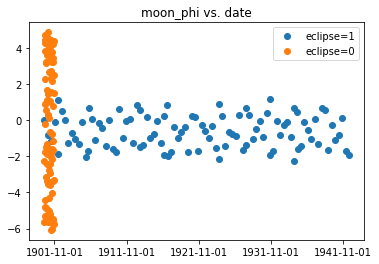

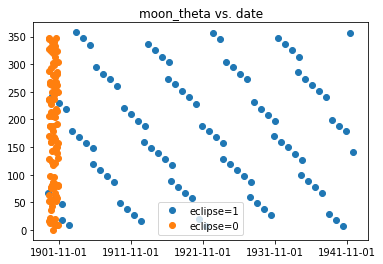

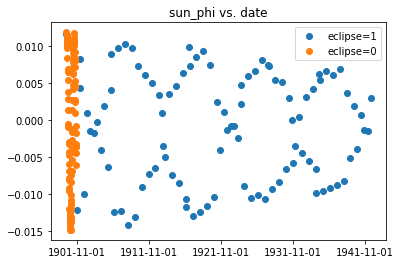

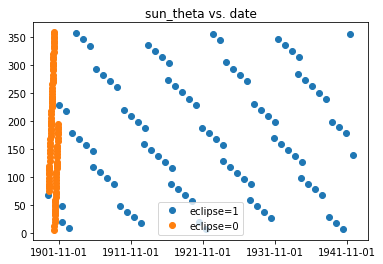

In [45]:
plot_parameter('moon_phi', 100)
plot_parameter('moon_theta', 100)
plot_parameter('sun_phi', 100)
plot_parameter('sun_theta', 100)

## Eclipse Incidence Prediction

This code handles model initialization, training and prediction to answer: "given a time and the position of the moon and sun, is an eclipse occuring?"

In [46]:
X = np.array(data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']])
X = np.append(X, [[d.jd] for d in data['ISO Date']], axis=1)
y = np.array(data['eclipse'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [47]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [KNeighborsClassifier(3),
    SVC(kernel="sigmoid", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]


classifiers = dict(zip(names, classifiers))

In [64]:
print('Selecting best classifier by test score')
best_clf = (None, None)
for name, clf in classifiers.items():
    print('Training %s classifier' % name)
    clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    test_score = clf.score(X_test, y_test)
    if test_score >= best_test_score: # Select top-performing classifier by test score
        best_clf = (name, clf)
print('\nBest classifier by test score:', best_clf[0])
print('Train score:', best_clf[1].score(X_train, y_train))
print('Test score:', best_clf[1].score(X_test, y_test))

Selecting best classifier by test score
Training Nearest Neighbors classifier
Training Linear SVM classifier
Training RBF SVM classifier
Training Decision Tree classifier
Training Random Forest classifier
Training Neural Net classifier
Training AdaBoost classifier
Training Naive Bayes classifier
Training QDA classifier

Best classifier by test score: QDA
Train score: 0.9979171234378426
Test score: 0.9991231915826392


Confusion matrix (non-normalized)


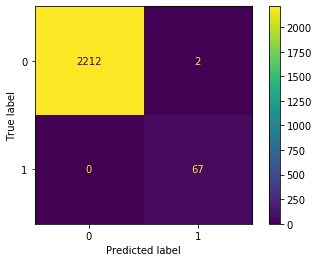

In [53]:
print('Confusion matrix (non-normalized)')
plot_confusion_matrix(best_clf[1], X_test, y_test)
plt.show()

Confusion matrix (normalized across predictions)


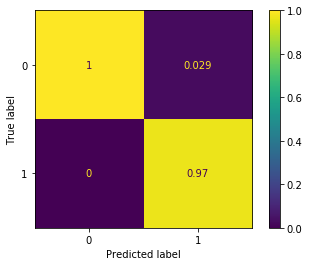

In [54]:
print('Confusion matrix (normalized across predictions)')
plot_confusion_matrix(best_clf[1], X_test, y_test, normalize='pred')
plt.show()

In [56]:
from sklearn.model_selection import GridSearchCV

Start grid search cross-validation on QDA classifier
Train score: 0.9979171234378426
Test score: 0.9991231915826392
Best reguliarization parameter: 1e-06


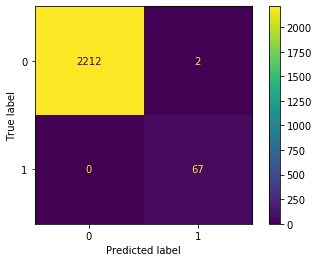

In [63]:
print('Grid search cross-validation on QDA classifier')
params = [{'reg_param': np.arange(0, 0.00001, 0.000001)}]
qda = QuadraticDiscriminantAnalysis()
clf = GridSearchCV(qda, params)
clf.fit(X_train, y_train)
plot_confusion_matrix(clf, X_test, y_test)
print('Train score:', clf.score(X_train, y_train))
print('Test score:', clf.score(X_test, y_test))
print('Best reguliarization parameter:', clf.best_params_['reg_param'])

## Eclipse Location Prediction

This code handles model initialization, training and prediction to answer: "given a time that an eclipse is occuring, the position of the moon, the position of the sun, where on Earth is the eclipse visible?"

### Latitude Prediction

We will start with making predictions on the latitude.

In [11]:
data = pd.read_csv('solar_eclipse_pos_data.csv')
data['ISO Date'] = data['ISO Date'].apply(lambda x: Time(x))

X = data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
X = pd.concat([X, pd.DataFrame([[d.jd] for d in data['ISO Date']])], axis=1)
y = data[['latitude']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [34]:
data = pd.read_csv('solar_eclipse_pos_data.csv')

X = data[['moon_theta', 'moon_phi', 'sun_theta', 'sun_phi']]
X = pd.concat([X, data['ISO Date'].str.split('T').apply(lambda x: to_jd(x[0].split('-')))], axis=1)
y = data[['latitude']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
# X_train = X_train + np.random.normal(0, 0.1, size=X_train.shape) additive Gaussian noise

In [37]:
def test_regressor(reg, X_train, X_test, y_train, y_test):
    reg.fit(X_train, y_train)
    plt.subplots(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    print('Training score:', reg.score(X_train, y_train))
    plt.scatter(y_train, reg.predict(X_train))
    plt.title('Predicted values vs. true values, training set')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    
    plt.subplot(1, 2, 2)
    print('Test score:', reg.score(X_test, y_test))
    plt.scatter(y_test, reg.predict(X_test))
    plt.title('Predicted values vs. true values, test set')
    plt.xlabel('True values')
    plt.ylabel('Predicted values')
    plt.tight_layout()
    plt.show()
    
def test_all_regressors(X_train, X_test, y_train, y_test):
    poly = PolynomialFeatures(degree=3)
    X_train_aug = poly.fit_transform(X_train)
    X_test_aug = poly.fit_transform(X_test)

    print('Linear regressor (with polynomial lifted features)')
    test_regressor(LinearRegression(), X_train_aug, X_test_aug, y_train, y_test)

    print('Random Forest Regressor')
    test_regressor(RandomForestRegressor(n_estimators=50), X_train, X_test, np.array(y_train).ravel(), np.array(y_test).ravel())
    
    print('Ridge regression (with cross-validated hyperparameter alpha)')
    test_regressor(RidgeCV(alphas=np.arange(0.1,100,0.1), fit_intercept=True), X_train, X_test, y_train, y_test)

Linear regressor (with polynomial lifted features)
Training score: 0.9504252174952674
Test score: 0.9141012582727398


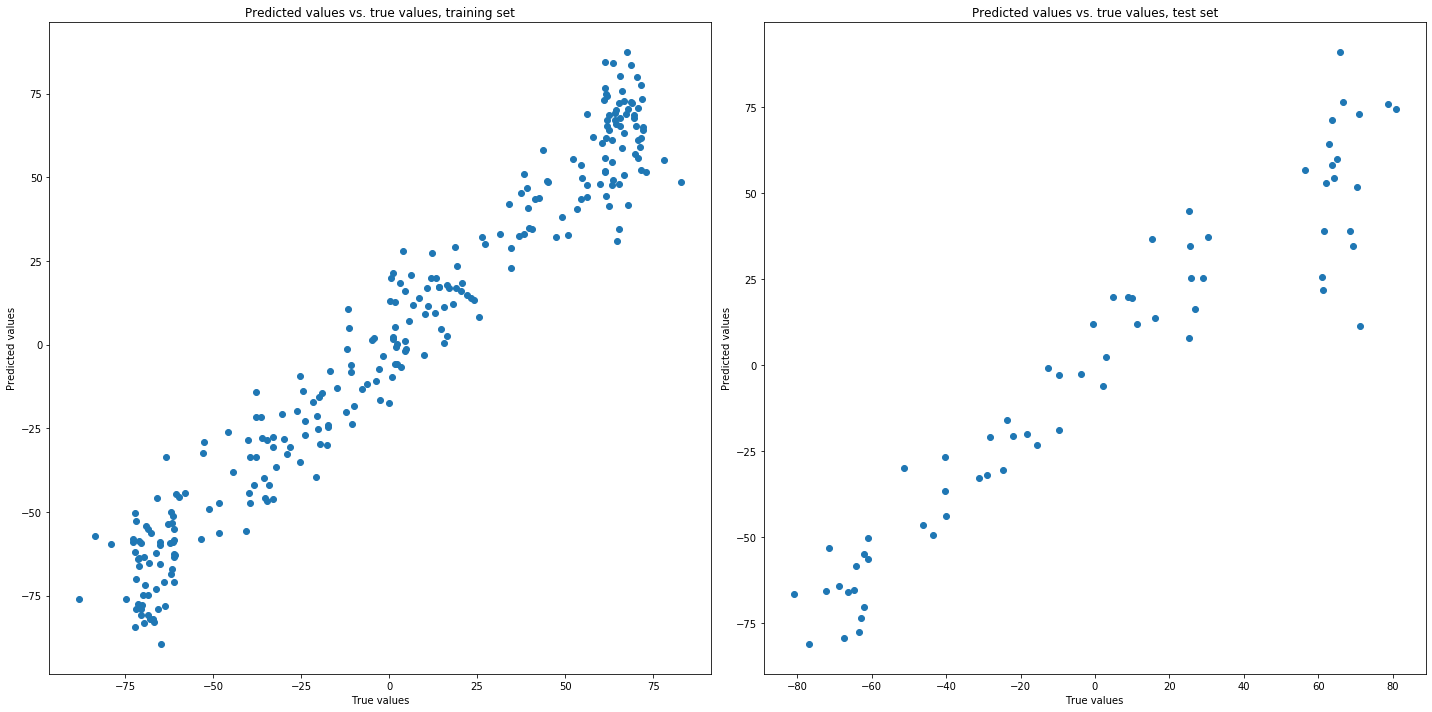

Random Forest Regressor
Training score: 0.9893238109402785
Test score: 0.9101815498941088


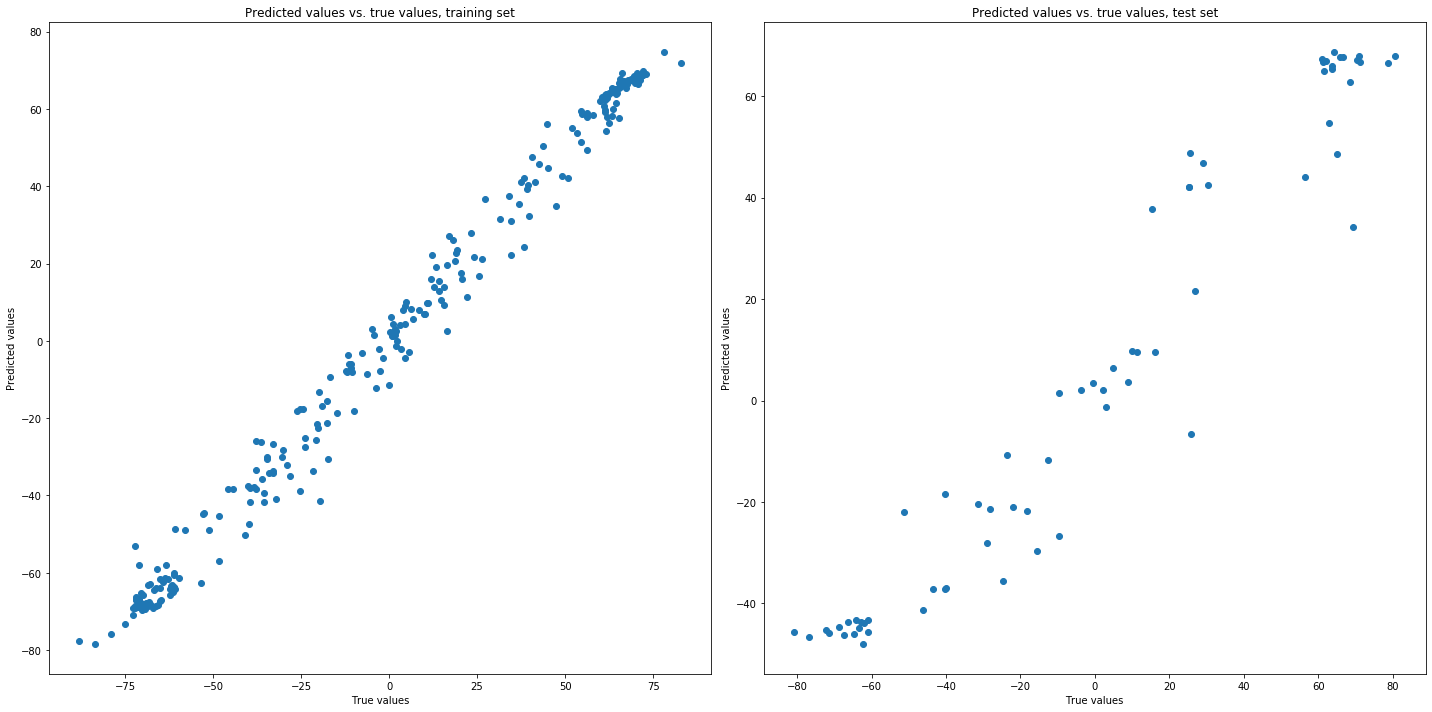

Ridge regression (with cross-validated hyperparameter alpha)
Training score: 0.8881713777036567
Test score: 0.905915359161906


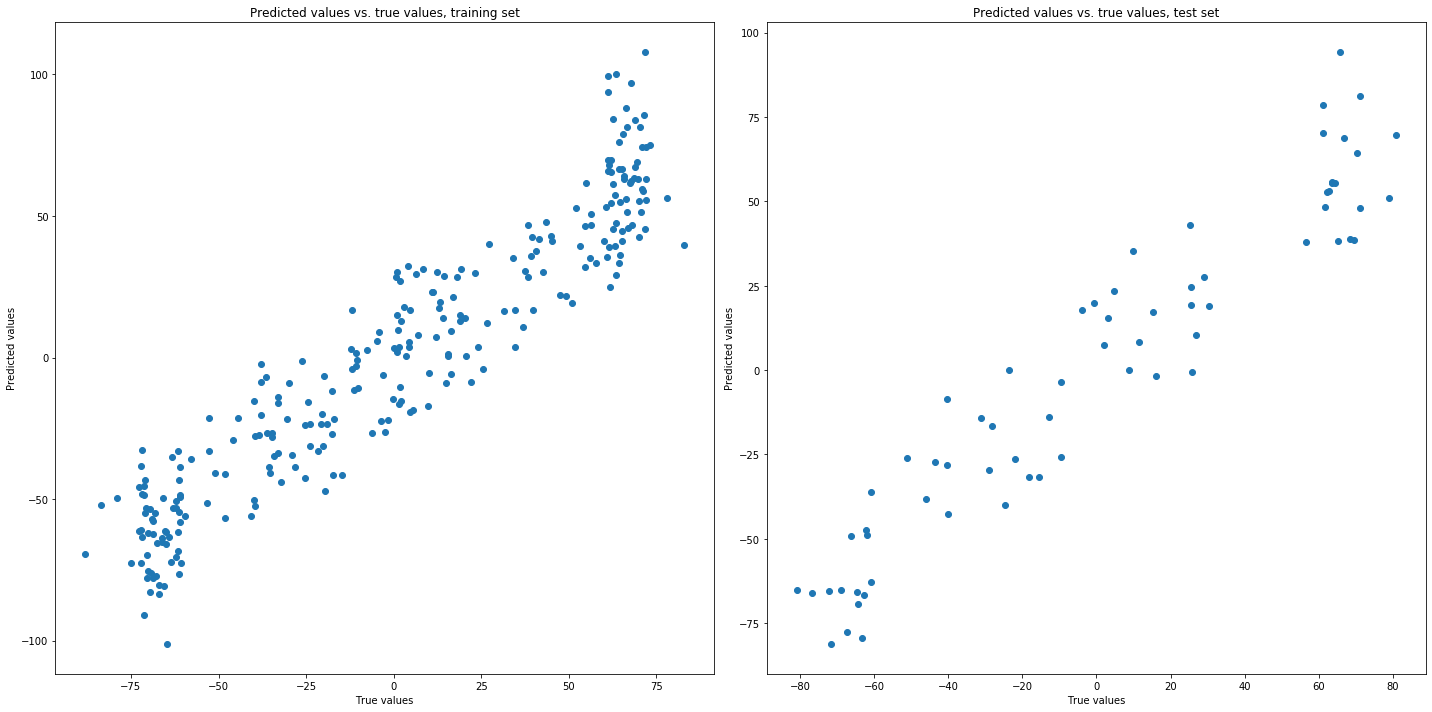

In [44]:
test_all_regressors(X_train, X_test, y_train, y_test)

### Longitude Prediction

Now, let's make predictions on the longitude.

It looks like we can achieve reasonably good performance when predicting an eclipse's latitude. Let's see what happens when we do the same for longitude.

In [45]:
# X remains the same, y is now longitude instead of latitude.
y = data[['longitude']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Linear regressor (with polynomial lifted features)
Training score: 0.33798781311035275
Test score: 0.17547749686051284


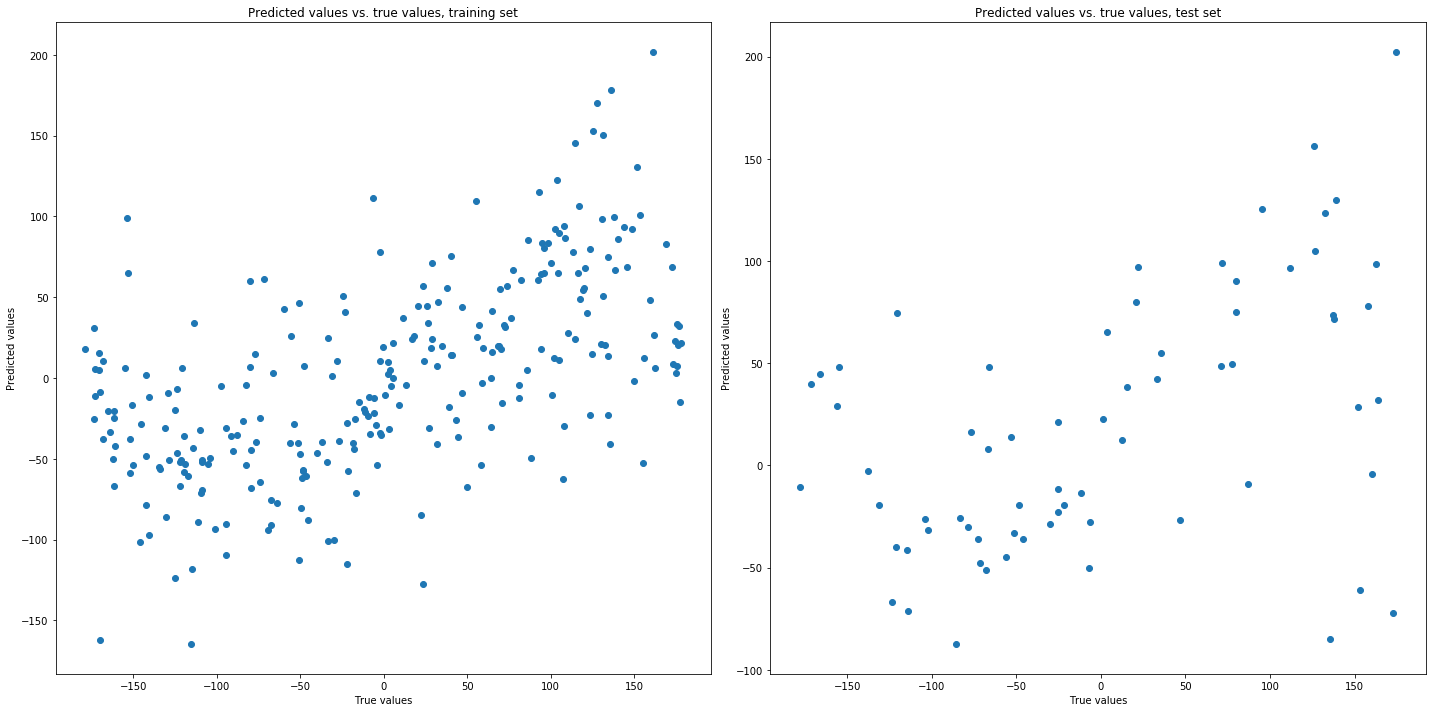

Random Forest Regressor
Training score: 0.8252503657410903
Test score: -0.1708288851236417


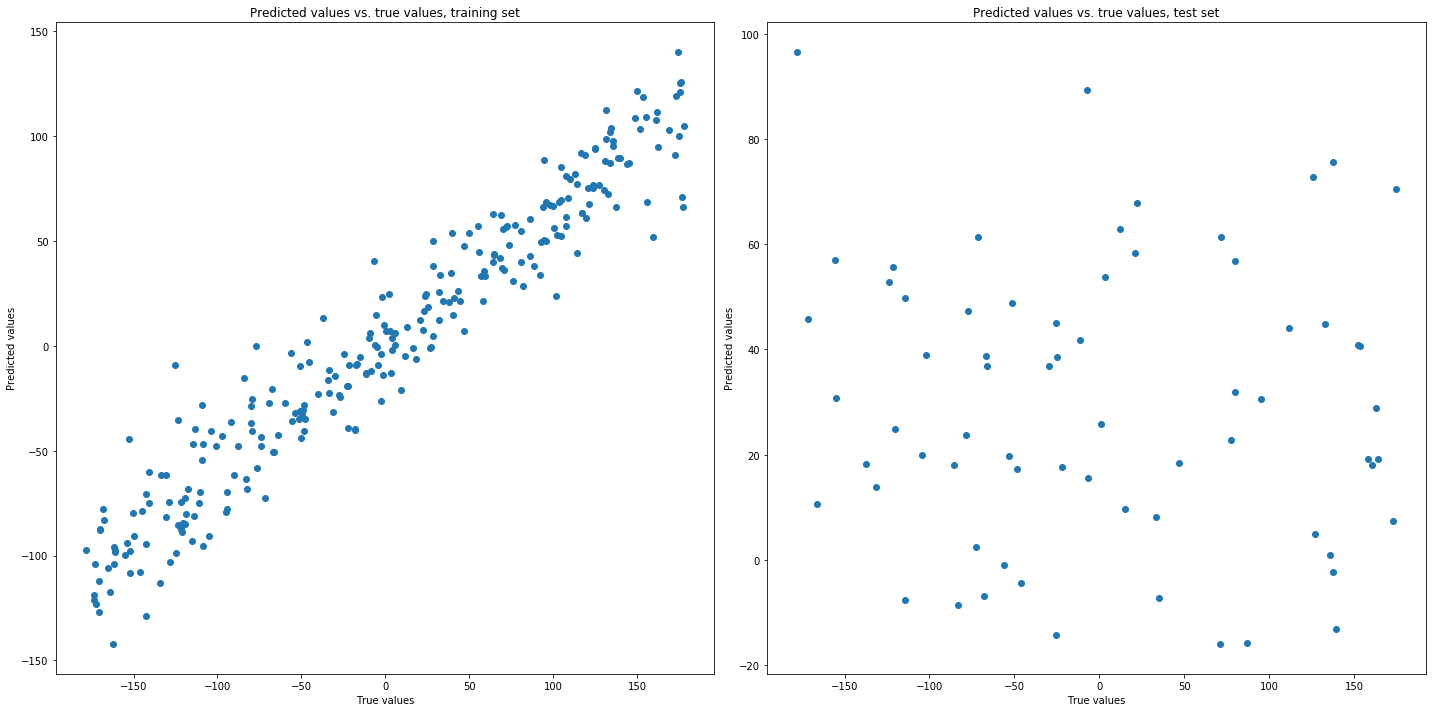

Ridge regression (with cross-validated hyperparameter alpha)
Training score: 0.17992493214016902
Test score: 0.17001799874055745


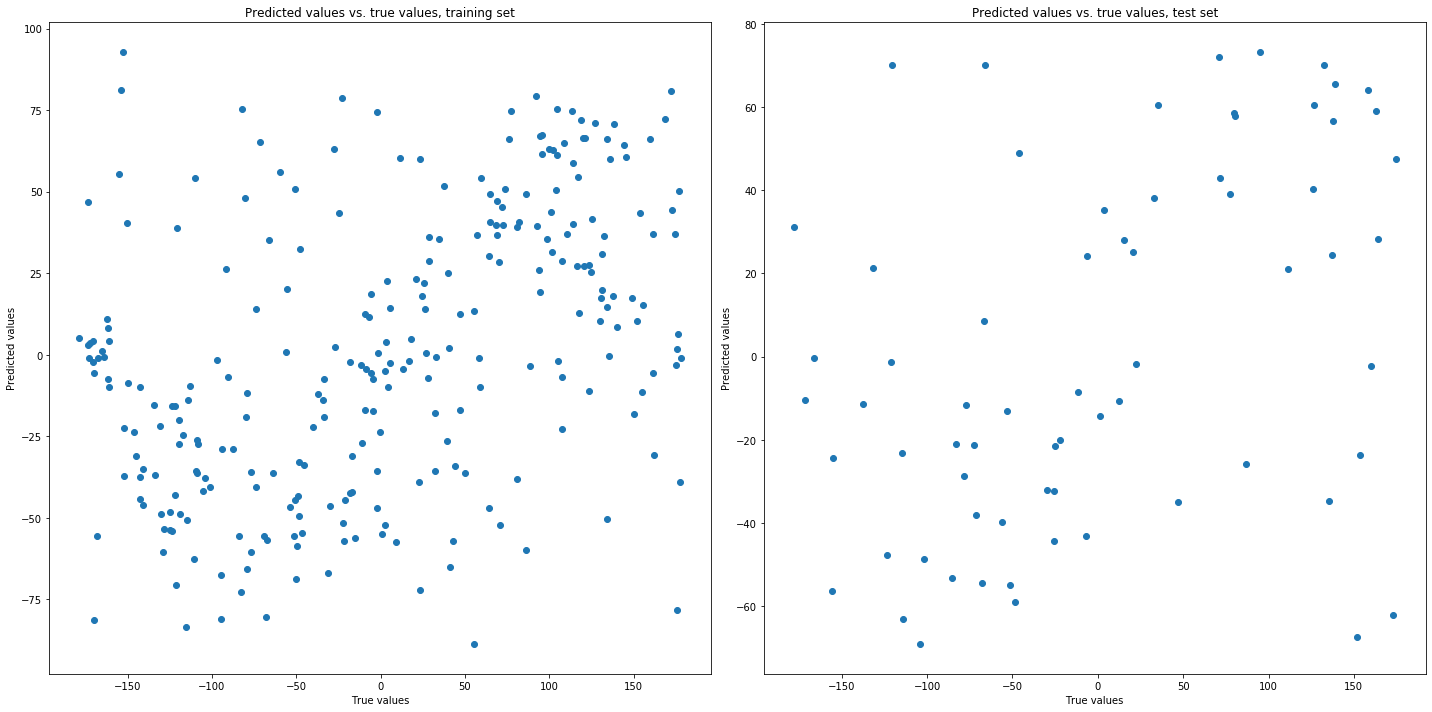

In [46]:
test_all_regressors(X_train, X_test, y_train, y_test)

The performance has now dropped significantly. Why is this the case? We refer to these visualizations.

In [56]:
def to_jd(calendar_date):
    month_labels = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
    months = dict(zip(month_labels, range(1, 13)))
    try:
        return sum(jdcal.gcal2jd(calendar_date[0], months[calendar_date[1]], calendar_date[2]))
    except KeyError: # if the month is already an integer 
        return sum(jdcal.gcal2jd(calendar_date[0], int(calendar_date[1]), calendar_date[2]))

def plot_locations(data):
    dates = data['Calendar Date'].str.split().apply(lambda calendar_date: to_jd(calendar_date))
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xlabel('Julian Day')
    plt.ylabel('Latitude')
    plt.title('Latitude vs. Julian Day')
    plt.scatter(dates, data['Latitude'])
    plt.show()
    
    fig, ax = plt.subplots(figsize=(20, 10))
    plt.xlabel('Julian Day')
    plt.ylabel('Longitude')
    plt.title('Longitude vs. Julian Day')
    plt.scatter(dates, data['Longitude'])
    
def plot_saros(data, n):
    saros = data[data['Saros Number'] == n]
    dates = saros['Calendar Date'].str.split().apply(lambda x: int(x[0]))

    
    plt.subplots(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.xlabel('Year')
    plt.ylabel('Latitude')
    plt.title('Latitude vs. Year, Saros %d' % n)
    plt.scatter(dates, saros['Latitude'])

    plt.subplot(1, 2, 2)
    plt.xlabel('Year')
    plt.ylabel('Longitude')
    plt.title('Longitude vs. Year, Saros %d' % n)
    plt.scatter(dates, saros['Longitude'])
    plt.show()

In [57]:
data = pd.read_csv('solar_eclipse_data.csv')
data['Latitude'] = data['Latitude'].apply(lambda x: convert_latitude(x))
data['Longitude'] = data['Longitude'].apply(lambda x: convert_longitude(x))

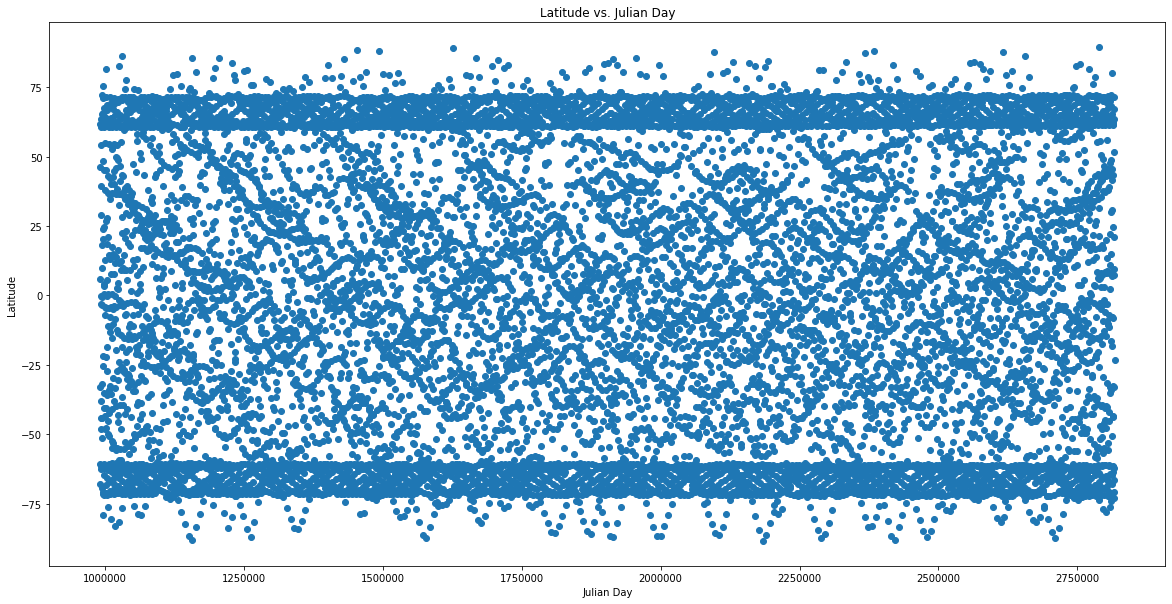

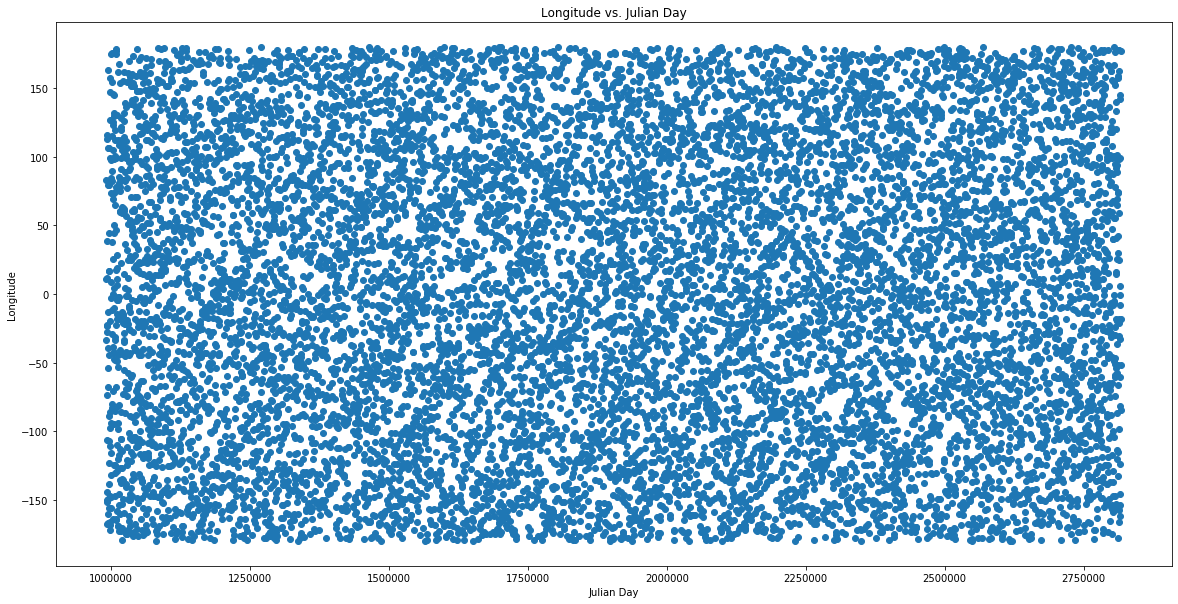

In [58]:
# Plot locations of all eclipses in dataset (~2000 BC to 3000 AD)
plot_locations(data)

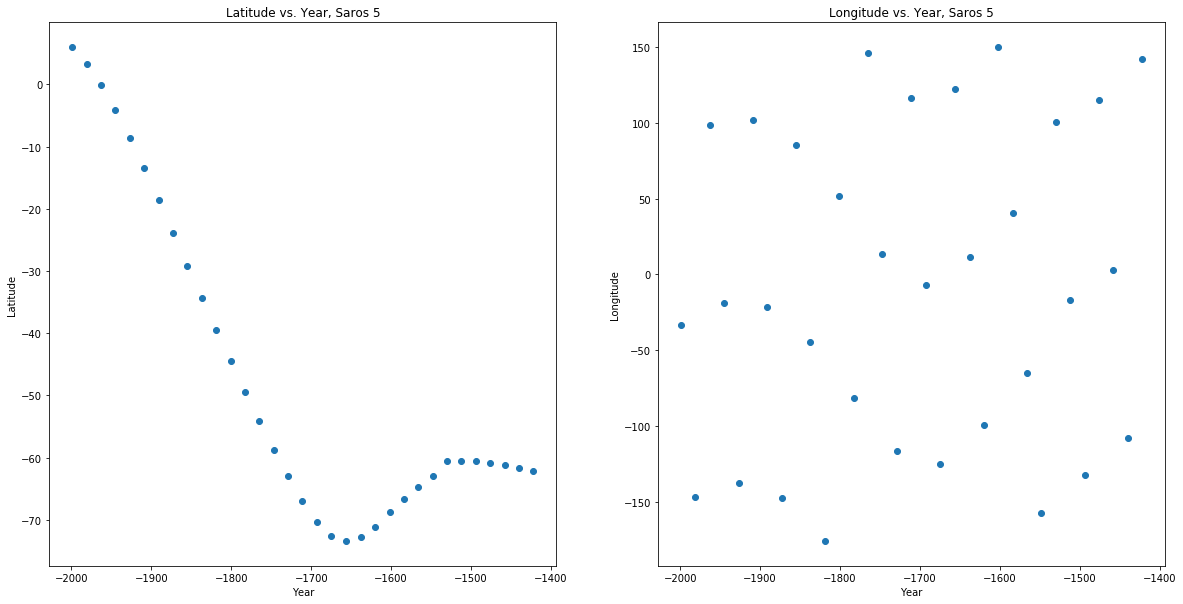

In [59]:
plot_saros(data, 5)

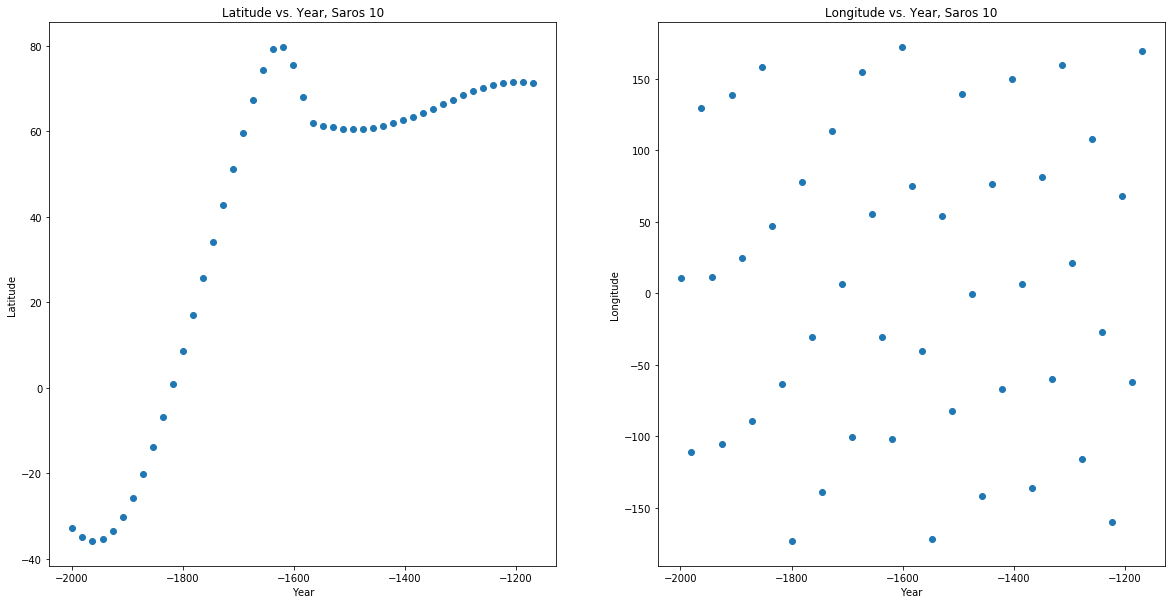

In [60]:
plot_saros(data, 10)

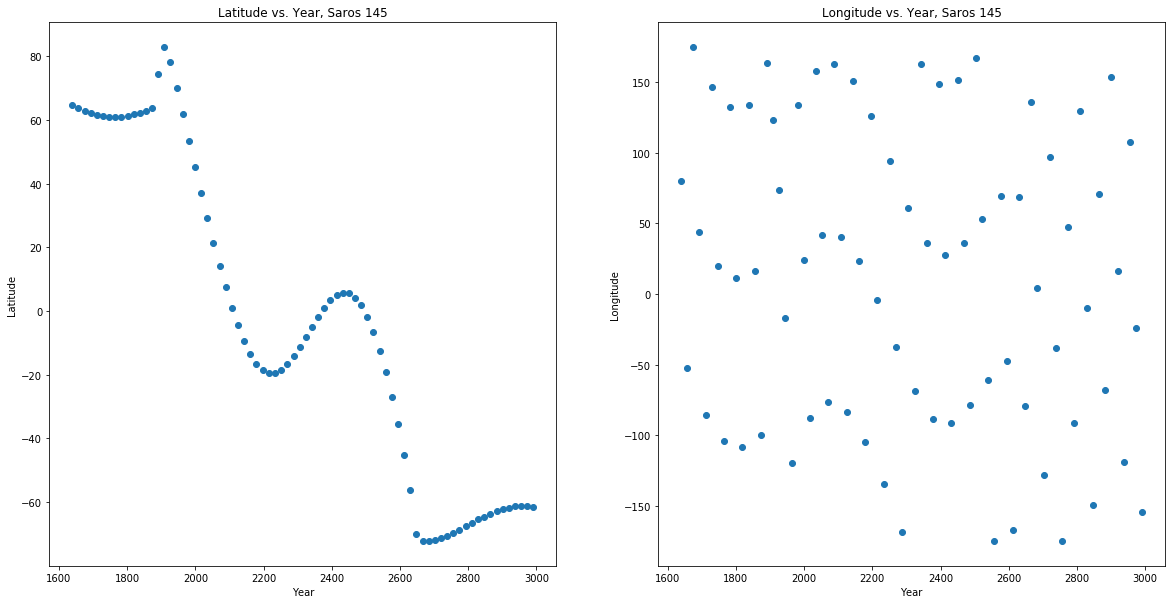

In [61]:
plot_saros(data, 145)